## 掛接 Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2
import tensorflow_datasets as tfds
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.applications.vgg16 import VGG16
from tqdm import tqdm,trange

## 載入資料

In [3]:
# 確認壓縮檔路徑
filepath='/content/drive/MyDrive/Hw3'
os.listdir(filepath)

['sample_submission.csv',
 'category.xlsx',
 '2022hw3.zip',
 'stanford_dogs',
 'prediction.csv']

In [4]:
# # 解壓縮檔案
#!unzip '/content/drive/MyDrive/Hw3/2022hw3.zip' -d '/content/drive/MyDrive/Hw3'

In [5]:
dirpath='/content/drive/MyDrive/Hw3/stanford_dogs/stanfor_dogs/'
os.listdir(dirpath) 

['test', 'train']

In [6]:
# imgSize=(100,100)
# imgShape=(100,100,3)
imgSize=(299,299)
imgShape=(299,299,3)
batchSize=32

# train generator
trainDataGenerator = ImageDataGenerator(rescale = 1/255,
                      # augmentation
                      rotation_range = 40,
                      shear_range = 0.3,
                      zoom_range = 0.3,
                      width_shift_range = 0.2,
                      height_shift_range = 0.2,
                      horizontal_flip=True,
                      validation_split=0.1)
valDataGenerator = ImageDataGenerator(rescale=1/255,validation_split=0.1)

trainBatch = trainDataGenerator.flow_from_directory(
    directory = dirpath+'train',
    target_size = imgSize,
    class_mode = 'categorical',
    shuffle = True,
    batch_size = batchSize,
    subset='training'
)

valBatch = valDataGenerator.flow_from_directory(
    directory = dirpath+'train',
    target_size = imgSize,
    class_mode = 'categorical',
    shuffle = False,
    batch_size = batchSize,
    subset='validation'
)

# test generator
testDataGenerator = ImageDataGenerator(rescale=1/255)

testBatch = testDataGenerator.flow_from_directory(
    dirpath,
    class_mode=None,
    shuffle = False,
    batch_size=batchSize,
    target_size= imgSize,
    classes=['test']
)


Found 10800 images belonging to 120 classes.
Found 1200 images belonging to 120 classes.
Found 8580 images belonging to 1 classes.


## 載入模型

In [7]:
from keras.applications.inception_v3 import InceptionV3
from keras import models
# base_model = tf.keras.applications.VGG16(
#     include_top = False,
#     weights = 'imagenet',
#     input_tensor = None,
#     input_shape=imgShape,

# )

# x = base_model.output
# x = layers.Dropout(0.5)(x)
# x = layers.GlobalAveragePooling2D()(x)

base_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (299,299,3))

model = models.Sequential()
model.add(base_model) # add pre_trained layers
model.add(layers.GlobalAveragePooling2D())
#model.add(Flatten()) # flatten to 1-D vector to prepare for fully connected layers
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(120, activation = 'softmax'))




#output_layer = layers.Dense(units = 120, activation = 'softmax')(x)


# freeze the weight
#base_model.trainable = False
model.layers[0].trainable = False

#model = tf.keras.Model(inputs = base_model.input, outputs = output_layer)

87924736/87910968 [==============================] - 1s 0us/step


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 120)               61560     
                                                        

In [9]:
# show the model stucture (截圖用)
model1 = tf.keras.Sequential([
    base_model,
    layers.Dropout(0.5),
    layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(120, activation="softmax")
])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 2048)        0         
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 120)               245880    
                                                                 
Total params: 22,048,664
Trainable params: 245,880
Non-trainable params: 21,802,784
_________________________________________________________________


## train model

In [10]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
epoch=30
history = model.fit(
  trainBatch,
  steps_per_epoch = trainBatch.samples // batchSize,
  
  #steps_per_epoch = len(trainBatch),
  validation_data = valBatch,
  validation_steps = valBatch.samples // batchSize,
  #validation_steps = len(valBatch),
  
  epochs=epoch,
  verbose=1
)

Epoch 1/30
337/337 [==============================] - 1904s 6s/step - loss: 1.7968 - accuracy: 0.5489 - val_loss: 0.5600 - val_accuracy: 0.8218
Epoch 2/30
337/337 [==============================] - 234s 694ms/step - loss: 1.0215 - accuracy: 0.7011 - val_loss: 0.4888 - val_accuracy: 0.8336
Epoch 3/30
337/337 [==============================] - 233s 691ms/step - loss: 0.9361 - accuracy: 0.7259 - val_loss: 0.5236 - val_accuracy: 0.8319
Epoch 4/30
337/337 [==============================] - 233s 691ms/step - loss: 0.8980 - accuracy: 0.7363 - val_loss: 0.4346 - val_accuracy: 0.8564
Epoch 5/30
337/337 [==============================] - 233s 690ms/step - loss: 0.8747 - accuracy: 0.7406 - val_loss: 0.4481 - val_accuracy: 0.8590
Epoch 6/30
337/337 [==============================] - 233s 691ms/step - loss: 0.8172 - accuracy: 0.7555 - val_loss: 0.4562 - val_accuracy: 0.8573
Epoch 7/30
337/337 [==============================] - 233s 692ms/step - loss: 0.8145 - accuracy: 0.7503 - val_loss: 0.4548 - v

## show the loss & accuracy curve

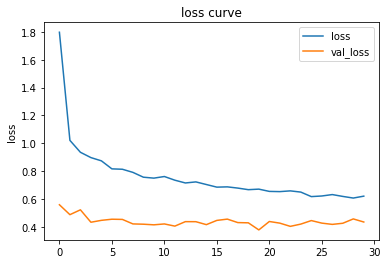

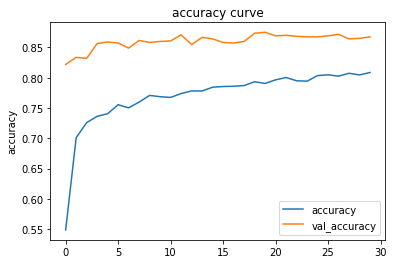

In [12]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## predict test data

In [13]:
prediction = model.predict(testBatch)
prediction

array([[3.5836900e-05, 1.9534030e-03, 4.4820164e-03, ..., 5.0516400e-07,
        6.1234999e-07, 3.4788866e-06],
       [5.3327494e-06, 9.9821246e-01, 6.4407186e-06, ..., 2.9637178e-08,
        2.8242571e-09, 3.0876492e-09],
       [1.9570282e-10, 2.3698384e-14, 3.4860243e-11, ..., 1.9714320e-11,
        3.6525034e-09, 6.9988493e-10],
       ...,
       [1.2176731e-07, 7.1557112e-17, 1.8614633e-13, ..., 4.8393740e-11,
        1.0152196e-12, 2.3620891e-10],
       [3.2839478e-12, 1.9196976e-16, 3.3177329e-11, ..., 4.6283402e-14,
        4.4040384e-13, 1.2370629e-11],
       [1.2110213e-10, 9.4940935e-14, 1.0761020e-11, ..., 8.9815151e-09,
        7.5876748e-08, 6.2040051e-08]], dtype=float32)

## 輸出結果

In [14]:
prediction_label=prediction.argmax(axis=1)
filename=testBatch.filenames
filename_new=testBatch.filenames
outputdf=pd.DataFrame()
for i in range(len(filename)) :
  filename_new[i]=filename[i][5:]

outputdf['Name']=filename_new
outputdf['Label']=prediction_label
outputdf.to_csv('/content/drive/MyDrive/Hw3/prediction.csv',index=False)